# K-Means Clustering
Cluster splats using K-Means clustering.
This is the offline "oracle" version of the clustering.

In [1]:
# Path to the CSV file containing the collected splats.
CSV_FILE_PATH = "data/collected_splats.csv"

# Number of clusters.
CLUSTERS = 8

In [2]:
import numpy as np
import polars as pl

from constants import IMAGE_HEIGHT, IMAGE_WIDTH


In [3]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in
                ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.UInt32
schema_dict["background_r"] = pl.UInt8
schema_dict["background_g"] = pl.UInt8
schema_dict["background_b"] = pl.UInt8
schema = pl.Schema(schema_dict)

In [4]:
# Load data.
data = pl.scan_csv(CSV_FILE_PATH, schema=schema)

## Extract the Splats from the data


In [5]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                     "background_b")).collect().to_numpy()

# Reshape into splats table per pixel.
splats = raw_splats.reshape((IMAGE_HEIGHT * IMAGE_WIDTH, raw_splats.shape[1] // 5, 5))


# Cluster Splats
For each pixel,
1. Run k-means clustering on all splats.
2. Within each cluster, commutatively sum the alpha and color values.

In [6]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import os
from sklearn.cluster import KMeans

In [7]:
# Restrict the number of threads to 1 for kmeans.
os.environ['OMP_NUM_THREADS'] = '1'

In [8]:
def cluster_pixel(pixel_splats, clusters):
    """Compute clustering on a single pixel."""

    # Get depth values.
    depths = pixel_splats[:, 1]

    # Run K-Means clustering.
    kmeans = KMeans(n_clusters=clusters).fit(depths.reshape(-1, 1))

    # Initialize clustering 2D list: cluster -> [[alpha, depth, *color], ...].
    pixel_clustering = [[] for _ in range(clusters)]

    # Loop through each splat and place it in the appropriate cluster.
    for splat_index, cluster_index in enumerate(kmeans.labels_):
        pixel_clustering[cluster_index].append(pixel_splats[splat_index])

    # Commutatively combine cluster values [[median depth, alpha, color], ...].
    depth_clusters = np.empty((clusters, 5))
    for cluster_index, cluster_splats in enumerate(pixel_clustering):
        # Convert to numpy array.
        cluster_splats_array = np.array(cluster_splats)

        # Compute fields.
        depth_clusters[cluster_index, 0] = np.median(cluster_splats_array[:, 1])
        depth_clusters[cluster_index, 1] = 1 - np.prod(1 - cluster_splats_array[:, 0])
        alpha_sum = np.sum(cluster_splats_array[:, 0])
        if alpha_sum:
            depth_clusters[cluster_index, 2:] = np.sum(
                cluster_splats_array[:, 0].reshape(-1, 1) * cluster_splats_array[:, 2:],
                axis=0) / alpha_sum
        else:
            depth_clusters[cluster_index, 2:] = np.zeros(3)

    return depth_clusters[np.argsort(depth_clusters[:, 0])]


## Do the Clustering
1. Shuffle the splats in each pixel.
2. Cluster the splats.

In [25]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

In [26]:
# Cluster shuffled splats.
clustered_splats = Parallel(n_jobs=-1)(delayed(cluster_pixel)(pixel_splats, CLUSTERS) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

In [27]:
def alpha_compose_pixel(pixel_clusters):
    # Define the transmittance and pixel color for the first cluster.
    transmittance = 1.0
    pixel_color = np.zeros(3)

    # Loop through remaining clusters.
    for _, cluster_alpha, *cluster_color in pixel_clusters:
        # Skip transparent cluster.
        if not cluster_alpha:
            continue

        # Exit once the transmittance is basically zero.
        if transmittance <= 0.001:
            break

        # Compute the pixel color.
        pixel_color += cluster_alpha * np.array(cluster_color) * transmittance

        # Compute the transmittance.
        transmittance *= 1 - min(1, cluster_alpha)

    # Return the computed pixel color.
    return pixel_color

In [28]:
computed_image = [alpha_compose_pixel(pixel_clusters) for pixel_clusters in tqdm(clustered_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the Computed Image



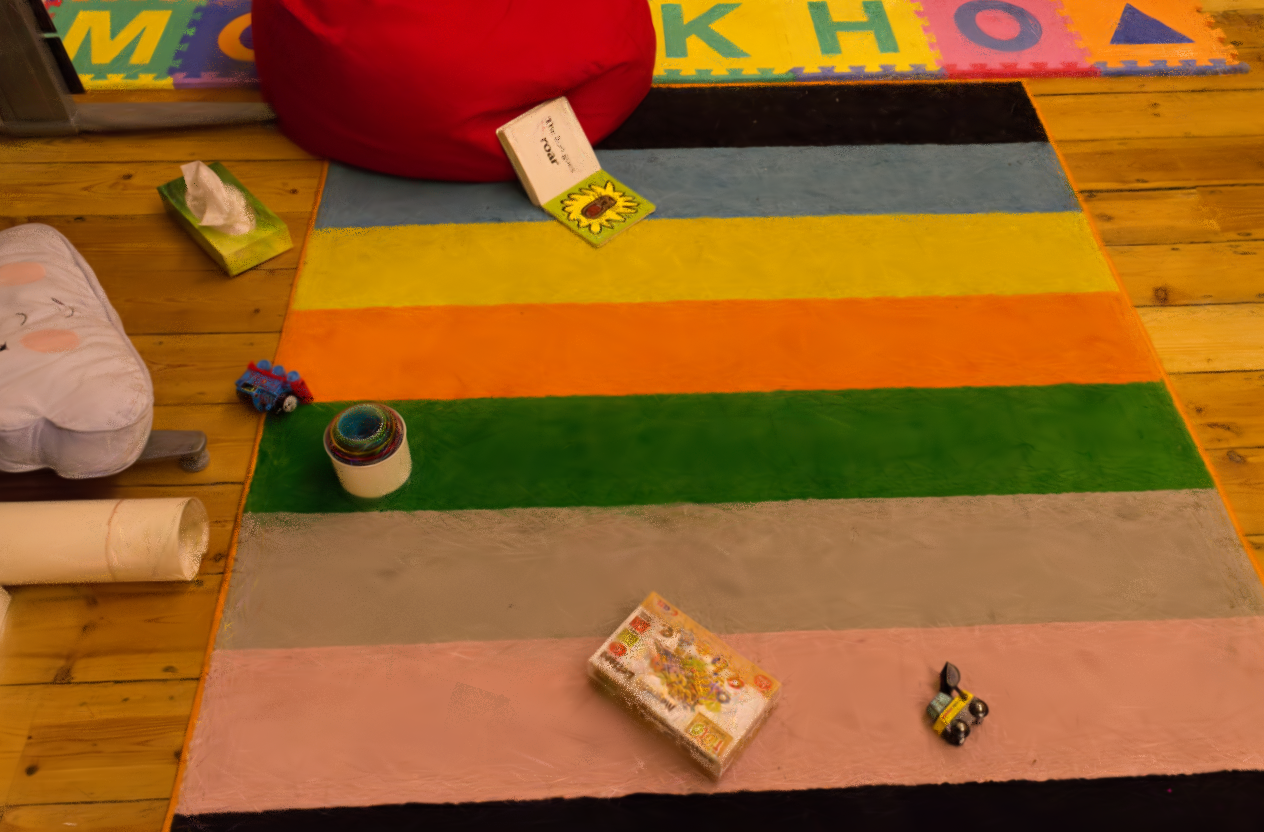

In [29]:
from image_handler import save_array_to_image
display(save_array_to_image(np.array(computed_image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 3), "k_means_clustering_2"))